# *Recommender Systems - Assinment I*
Guy Gonen -

Viktoria Roos - 321993198


In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import math

### Part 1 - Load the Data

In [4]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 4/xgFYKVv6sxQQlZTYaGMtZ079SjL9zKBK1X9xnCuQ37E9SA9aiu3BONs
def download_file_load_df(id, filename):
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile('train.csv')  
  return pd.read_csv('train.csv') 

import pandas as pd
train = download_file_load_df('1C8hzWpstNY3VJufQii583NydD6jlnwci', 'train.csv')
test = download_file_load_df('1153slQ9BawpVRFK4GTcU41JQjH6mdTBW', 'test.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


#### Loaded Train Data

,Unnamed: 0,user_id,business_id,stars,text
0,0,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5.0,Super simple place but amazing nonetheless. It...
1,1,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5.0,Small unassuming place that changes their menu...
2,2,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5.0,Lester's is located in a beautiful neighborhoo...


'Train Data - 4209336 records'

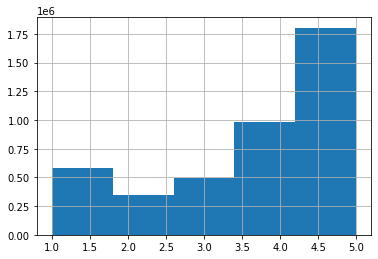

In [76]:
display(train.head(3))
display('Train Data - {0} records'.format(train.shape[0]))
display(train['stars'].hist(bins=5))

#### Loaded Test Data

,Unnamed: 0,user_id,business_id,stars,text
0,0,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5.0,Super simple place but amazing nonetheless. It...
1,1,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5.0,Small unassuming place that changes their menu...
2,2,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5.0,Lester's is located in a beautiful neighborhoo...


'Test Data - 1052334 records'

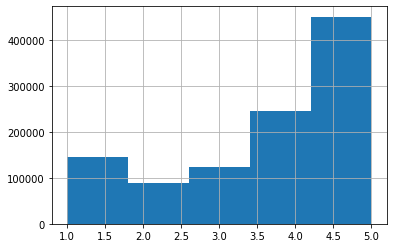

In [77]:
display(train.head(3))
display('Test Data - {0} records'.format(test.shape[0]))
display(test['stars'].hist(bins=5))

### Part 2 - Implement Measures:
RMSE:
RMSE has the benefit of penalizing large errors more, which is great in out case, since we want our predicted raiting be as close to the actual rating as possible. In addition, RMSE doesn't use absolute value which make it more convinient for mathematical evaluations.



In [0]:
def get_rmse(data, pred_method):
  sum = 0
  for row in data.itertuples(index=False):
    sum += (row.stars - pred_method(row.user_id,row.business_id))**2
  avg = sum/data.shape[0]
  return math.sqrt(avg)

# Question 3:

Create ReccommenerSystem class in order to train our model

In [0]:
class RecommenderSystem:
  def __init__(self,model_trainnig_data):
    self.model_trainnig_data = model_trainnig_data
    self.model_trainnig_data = self.model_trainnig_data[self.model_trainnig_data['user_id'].notna()]
    self.model_trainnig_data = self.model_trainnig_data[self.model_trainnig_data['stars'].notna()]
    self.model_trainnig_data = self.model_trainnig_data[self.model_trainnig_data['business_id'].notna()]
    self.items_number = self.model_trainnig_data['business_id'].nunique()
    self.users_number = self.model_trainnig_data['user_id'].nunique()
    self.__users = self.model_trainnig_data['user_id'].unique()
    self.__items = self.model_trainnig_data['business_id'].unique()
    users_indexes = np.arange(self.__users.shape[0]) 
    self.users_dic = dict(zip(self.__users,users_indexes))
    items_indexes = np.arange(self.__items.shape[0])
    self.items_dic = dict(zip(self.__items,items_indexes))


  def __add_unused_data_by_column(self, column_name):
    unused_data = self.validation[~(self.validation[column_name].isin(self.train[column_name]))]
    data_from_validation_to_train = unused_data.drop_duplicates(subset=column_name)
    display("Initial train size: {0} which is {1:.2f} of the dataset".format(self.train.shape[0],self.train.shape[0]/self.model_trainnig_data.shape[0]))
    self.train = self.train.append(data_from_validation_to_train)
    unused_data = pd.concat([unused_data,data_from_validation_to_train]).drop_duplicates(keep=False)
    _, val_to_train = train_test_split(unused_data, test_size=0.4)
    self.train = self.train.append(val_to_train)
    display('After opperation train size: {0} which is {1:.2f} of the dataset'.format(self.train.shape[0],self.train.shape[0]/self.model_trainnig_data.shape[0]))
    display("Initial validation size: {0} which is {1:.2f} of the dataset".format(self.validation.shape[0],self.validation.shape[0]/self.model_trainnig_data.shape[0]))
    self.validation = pd.concat([self.validation, data_from_validation_to_train, val_to_train]).drop_duplicates(keep=False)
    display("After opperation validation size: {0} which is {1:.2f} of the dataset".
            format(self.validation.shape[0],self.validation.shape[0]/self.model_trainnig_data.shape[0]))


  def __add_unused_users(self):
    self.__add_unused_data_by_column('user_id')


  def __add_unused_items(self):
    self.__add_unused_data_by_column('business_id')


  def split_data(self, train_size):
    display("Split training data into train and validation...")
    display("Initial split - test size {0}%".format(train_size*100))
    display('-----------------------------------------------------------------------------')
    self.train, self.validation = train_test_split(self.model_trainnig_data, test_size=1-train_size)
    display('Move missing users from validation to train....')
    self.__add_unused_users()
    display('-----------------------------------------------------------------------------')
    display('Move missing businesses from validation to train....')
    self.__add_unused_items()


  # rand an array of size rows_number*columns_number with non-zero values in the range of [-1,1] 
  def __rand_array(self, rows_number, columns_number):
    return (np.random.random_sample((rows_number, columns_number)) - 1)*-1*np.random.choice([1,-1], size=(rows_number, columns_number))


  def __RMSE(self):
    sum = 0
    for row in self.validation.itertuples(index=False):
      sum += (row.stars - self.__predict(row.user_id,row.business_id))**2
    avg = sum/self.validation.shape[0]
    return math.sqrt(avg)


  def rmse_clc(self, data):
    sum = 0
    for row in data.itertuples(index=False):
      sum += (row.stars - self.__predict(row.user_id,row.business_id))**2
    avg = sum/data.shape[0]
    return math.sqrt(avg)


  def __rand_initial_params(self,latent_features_number):
    self.__P = self.__rand_array(self.users_number,latent_features_number)
    self.__Q = self.__rand_array(self.items_number,latent_features_number)
    self.__users_bias = self.__rand_array(self.users_number,1)
    self.__items_bias = self.__rand_array(self.items_number,1)



  def __predict(self,user,item):
    user_index = self.users_dic[user]
    item_index = self.items_dic[item]
    return (self.M + self.__items_bias[item_index] + self.__users_bias[user_index] + self.__Q[item_index]@self.__P[user_index])[0]


  def predict(self,user,item):
    user_index = self.users_dic[user]
    item_index = self.items_dic[item]
    return (self.M + self.items_bias[item_index] + self.users_bias[user_index] + self.Q[item_index]@self.P[user_index])[0]


  def __train_itteration(self,l,Y):
    for row in self.train.itertuples(index=False):
      user = row.user_id
      item = row.business_id
      user_index = self.users_dic[row.user_id]
      item_index = self.items_dic[row.business_id]
      pridected_rating = self.__predict(user,item)
      err = row.stars - pridected_rating
      self.__items_bias[item_index] = self.__items_bias[item_index] + Y*(err - l*self.__items_bias[item_index])
      self.__users_bias[user_index] = self.__users_bias[user_index] + Y*(err - l*self.__users_bias[user_index])
      (self.__Q[item_index], self.__P[user_index]) = (self.__Q[item_index] + Y*(err*self.__P[user_index]-l*self.__Q[item_index]),
                                          self.__P[user_index] + Y*(err*self.__Q[item_index]-l*self.__P[user_index]))
      
      
  def get_results_df(self,learning_rates, reularizations):
    header = []
    for l_rt in learning_rates:
      for reg in reularizations:
        header.append('lr = {0}, reg = {1}'.format(l_rt,reg))
    rows =['Train RMSE','Validation RMSE','Epocs']
    return pd.DataFrame(columns = header, index=rows)


  def TrainBaseModel(self, latent_features_number):
    self.split_data(0.65)
    display('-----------------------------------------------------------------------------')
    display('SVD model training for {0} latent_features began...'.format(latent_features_number))
    self.M = self.train['stars'].mean()
    learning_rates = [0.05, 0.01, 0.005]
    reularizations = [0.05, 0.02]
    best_rmse = 100
    self.results = self.get_results_df(learning_rates, reularizations)
    for l_rt in learning_rates:
      for reg in reularizations:
        display('-----------------------------------------------------------------------------')
        display('Start training for: lr = {0}, reg = {1}'.format(l_rt,reg))
        self.__rand_initial_params(latent_features_number)
        iterations = 0
        val_error = self.__RMSE()
        while True:
          self.__train_itteration(reg,l_rt)
          iterations+=1
          updated_error = self.__RMSE()
          if (updated_error > val_error or val_error-updated_error < 0.005):
            val_error = updated_error
            break
          val_error = updated_error
        val_error = self.__RMSE()
        train_error = self.rmse_clc(self.train)
        res_column = self.results['lr = {0}, reg = {1}'.format(l_rt,reg)]
        res_column['Train RMSE'] = train_error
        res_column['Validation RMSE'] = val_error
        res_column['Epocs'] = iterations
        if val_error < best_rmse :
          best_rmse = val_error
          self.users_bias = np.copy(self.__users_bias)
          self.items_bias = np.copy(self.__items_bias)
          self.P = np.copy(self.__P)
          self.Q = np.copy(self.__Q)
          best_params = 'lr = {0}, reg = {1}'.format(l_rt,reg)
    display('-----------------------------------------------------------------------------')
    display(self.results)
    display('End of training and params tunning. Best Results for {0}'.format(best_params))
    

Run the model:

In [0]:
SVD = RecommenderSystem(train)

### SVD - 20 latent features

In [7]:
SVD.TrainBaseModel(20)

'Split training data into train and validation...'

'Initial split - test size 65.0%'

'-----------------------------------------------------------------------------'

'Move missing users from validation to train....'

'Initial train size: 2736067 which is 0.65 of the dataset'

'After opperation train size: 3005140 which is 0.71 of the dataset'

'Initial validation size: 1473267 which is 0.35 of the dataset'

'After opperation validation size: 1204194 which is 0.29 of the dataset'

'-----------------------------------------------------------------------------'

'Move missing businesses from validation to train....'

'Initial train size: 3005140 which is 0.71 of the dataset'

'After opperation train size: 3008846 which is 0.71 of the dataset'

'Initial validation size: 1204194 which is 0.29 of the dataset'

'After opperation validation size: 1200488 which is 0.29 of the dataset'

'-----------------------------------------------------------------------------'

'SVD model training for 20 latent_features began...'

'-----------------------------------------------------------------------------'

'Start training for: lr = 0.05, reg = 0.05'

'-----------------------------------------------------------------------------'

'Start training for: lr = 0.05, reg = 0.02'

'-----------------------------------------------------------------------------'

'Start training for: lr = 0.01, reg = 0.05'

'-----------------------------------------------------------------------------'

'Start training for: lr = 0.01, reg = 0.02'

'-----------------------------------------------------------------------------'

'Start training for: lr = 0.005, reg = 0.05'

'-----------------------------------------------------------------------------'

'Start training for: lr = 0.005, reg = 0.02'

'-----------------------------------------------------------------------------'

,"lr = 0.05, reg = 0.05","lr = 0.05, reg = 0.02","lr = 0.01, reg = 0.05","lr = 0.01, reg = 0.02","lr = 0.005, reg = 0.05","lr = 0.005, reg = 0.02"
Train RMSE,0.798839,0.889847,0.900261,0.968912,1.0044,1.02523
Validation RMSE,1.54617,1.58157,1.54638,1.58925,1.5623,1.59482
Epocs,3,2,9,7,13,12


'End of training and params tunning. Best Results for lr = 0.05, reg = 0.05'

In [19]:
test_set = test[test['user_id'].notna()]
test_set = test_set[test_set['business_id'].notna()]
test_set = test_set[test_set['stars'].notna()]
untrained_users_data = test_set[~(test_set['user_id'].isin(SVD.train['user_id']))]
untrained_items_data = test_set[~(test_set['business_id'].isin(SVD.train['business_id']))]
test_set = pd.concat([test_set, untrained_users_data, untrained_items_data]).drop_duplicates(keep=False)
test_set.head(3)

,Unnamed: 0,user_id,business_id,stars,text
0,4339035,SQP77ENmGEyVD4uUmmvJNw,NCHS7mgfVAf6EbYVb2qSSQ,2,Update 12\/15.\r\nI have been working with man...
1,1007359,NtD-rHQYR0Ke2uMGArABoA,ZV1DPIxOWvYuU0lHPj7SDw,4,I must say this restaurant is fantastic. Over ...
2,146770,51SzvpuYXsIXdc13w0jcEQ,t10X85k_m8RuAZZgoMzvXg,3,Anyone who's ever tried to book a hotel with m...


#### Test our SVD Model

In [20]:
test_rmse = get_rmse(test_set, (lambda user, item: SVD.predict(user, item)))
display('SVD test eror:{0}'.format(test_rmse))

'SVD test eror:1.5581669831840723'